In [1]:
# Dependencies
import numpy as np
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
from datetime import date, datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

## 1-Introduction


Airbnb is one of the biggest companies, and its dominance over the market can only make the competition jealous of its success. This company provides a platform so home owners, also known as hosts, can offer a place to stay to travelers in search of a cheaper solution than going for a hotel. The platform rewards outstanding hosts by providing them with the status of "Superhost" by opposition of being a regular host.   

The goal of this project is to dive in a little more on that topic in order to better understand the difference between these two status. We will take a look at a Airbnb dataset from the city of Seattle provided by Kaggle. 


## 2-Business Problem

In this project, I will investigate the Seattle Airbnb dataset to further understand how a successful listing is being recognized by a traveler. More specifically, we asked these three questions:

    - Is there a Price Difference in Terms of the Price Paid for a Bed Between a Regular Versus a Superhost?
    - Is There a Difference in the Years of Experience Between Regular versus a Superhost?
    - Is There a Difference in the Type of Housing Offered by Regular versus Superhosts?
 

In [2]:
# Functions used throughout this notebook

def reading_csv(file):
    """
    Parameters:
    file (str): Input csv file that you want to import 
    
    Returns: 
    Object containing the content of the csv file
    """
    
    f = pd.read_csv(file)
    return f 


def print_dim(names, df):
    """
    Parameters:
    names str(): A string that defines what you are using as an input
    df: The dataframe for which you want the dimensions to be printed
    
    Returns:
    A line (string) with the dimensions of the dataframe
    """
    
    print("The dataset {} has {} rows and {} columns".format(names, df.shape[0], df.shape[1]))


def data_drop_duplicates(df):
    """
    Parameters:
    Object corresponding to the dataframe for which duplicates should be removed
    
    Return:
    Dataframe without any duplicates
    """

    print("The number of duplicates is {}".format(df.duplicated().sum()))
    df = df.drop_duplicates(inplace=True)
    return df


def data_info(df):
    """
    Parameters:
    df: Object corresponding to the dataframe for which information should be displayed
    
    Return:
    Information about the dataframe
    """
    
    print("Data Information:\n {}".format(df.info()))

    
def data_nan(df):
    """
    Parameters:
    df: Object corresponding to the dataframe for which
    number of missing values per columns should be displayed
    
    Return:
    Table with the amount of missing values for each feature
    """

    print("Amount of Nan per columns:\n {}".format(pd.isnull(df).sum()))

def data_describe(df):
    """
    Parameters:
    df: Object corresponding to the dataframe for which we want to extract
    the descriptive statistics
    
    Return:
    Table with the mean, standard deviation, minimum, maximum, and interquartile.
    """
    print("Descriptive Statistics:\n {}".format(df.describe()))
    
    
def host_in_year(df, col, new_col):
    """
    Parameters:
    df: Oobject corresponding to the dataframe
    col (str): column that contains information about the number of days
    new_col (str): The new name for the column we want to create to replace the previous one
    
    Return:
    A new column in the dataframe with the number of days converted to years
    """
    
    df['tmp'] = datetime.now() - df[col]
    df[new_col] = df['tmp'].apply(lambda x : x.days/365)
    df = df.drop(['tmp', col], axis=1)
    return df


def replace_characters(main_string, chars, new_string):
    """
    Parameters:
    main_string (str): The string for which you want to make the replacement
    chars (str): The character that you want to replace
    new_string (str): The new string that will replace the previous string (chars)
    
    Return:
    The original string, but with the new characters now incorporated.
    """
    
    for char in chars:
        try :
            if char in main_string:
                main_string = main_string.replace(char, new_string)
        except:
            continue       
    return main_string


def compare_plots(group1, group2, feature):
    """
    This function will create side-by-side plots for two groups in order 
    to visually compare them
    
    Parameters:
    group1 (obj): Dataframe of the first group
    group2 (obj): Dataframe of the second group
    feature (str): Feature that you want to compare
    
    Return:
    Side-by-side counterplot of the two groups 
    """
    
    plt.tight_layout()
    plt.subplot(1,2,1)
    plt.xticks(rotation='vertical')
    sns.countplot(group1[feature])
    plt.subplot(1,2,2)
    sns.countplot(group2[feature])
    plt.xticks(rotation='vertical')
    plt.tight_layout()
    plt.show()

def cat_imputer(strategy, df, impute_features):
    """
    Parameters:
    strategy (str): Specifiy which strategy you want to use for imputation (e.g., 'most_frequent')
    df (obj): Dataframe for imputation
    impute_features (str): Feature for which you want to perform the imputation
    
    """
    
    imputer = SimpleImputer(strategy=strategy)
    df_imp = imputer.fit_transform(df[impute_features])
    imputed_features = pd.DataFrame(data=df_imp, columns=impute_features)
    df = pd.concat([df.drop(impute_features, axis=1), imputed_features], axis=1)
    return df

## 3-Data Exploration 
In the next few lines, I will proceed to the exploration of the dataset to understand the distribution of the different features, the number of missing values, the type of features. Furthermore, I will remove duplicated observations in order to eliminate any biases from the descriptive statistics.

In [3]:
# Loading the dataset
listings = reading_csv('seattle/listings.csv')


In [4]:
# Removing duplicated (if any), reporting general information, and number of NaNs 

print_dim('Calendar', listings)
data_drop_duplicates(listings)
print()
data_info(listings)
print()
data_nan(listings)
print()
data_describe(listings)
print()

The dataset Calendar has 3818 rows and 92 columns
The number of duplicates is 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url     

### 3.1-Selection of features
In order to perform our analysis, I will only keep a subset of features that are the most pertinent for the questions that I will try to answer. In addition, I will create variables that will contain lists of binary, numerical, and categorical features. That will become handy in the subsequent steps.

In [5]:
# Revelant features that I found interesting to answer my questions
features = ['price', 'host_since', 'host_response_rate', 'host_response_time', 
            'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 
            'host_identity_verified', 'neighbourhood', 'property_type', 'room_type',
            'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'minimum_nights',
            'has_availability', 'number_of_reviews', 'review_scores_rating', 
            'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification']

# Assign variables to their respective groups
bin_vars = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability'
            'require_guest_profile_picture', 'require_guest_phone_verification']
target_var = 'price'
num_vars = ['host_response_rate', 'host_acceptance_rate', 'accommodates', 'bathrooms', 'bedrooms',
            'beds', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'host_in_years']
cat_vars = ['host_response_time', 'neighbourhood', 'property_type', 'room_type', 'bed_type',
            'cancellation_policy', ]

# Extraction of the features from the dataset of interest
df = listings[features]


## 4-Data preparation
For this step, we will prepare the data in order to remove or impute missing values according to the situation. Furthermore, we will proceed to re-encode some values to make them more usable for the analysis. For instance, it is usually recommended to encode binary features as "0/1".


In [6]:
# Converting "host_since" feature to datetime format, and transforming it to new feature: 'host_in_year'
df['host_since'] = pd.to_datetime(df['host_since'], format='%Y-%m-%d')
df = host_in_year(df, 'host_since', 'host_in_years')

# Remove the dollar sign and convert the price feature as a float
df['price'] = df['price'].apply(lambda x : replace_characters(x, ['$', ','], '')).astype(float)

# Remove the '%' sign from the host_response_rate feature, and convert to float
df['host_response_rate'] = df['host_response_rate'].apply(lambda x : replace_characters(x, '%', '')).astype(float)

# Remove the '%' sign from the host_acceptance_rate feature, and convert to float
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(lambda x : replace_characters(x, '%', '')).astype(float)

# Re-encode the the values for host_is_superhost into {0,1}
df['host_is_superhost'] = df['host_is_superhost'].map({'t':1, 'f':0})

# Re-encode the the values for host_has_profile_pic into {0,1}
df['host_has_profile_pic'] = df['host_has_profile_pic'].map({'t':1, 'f':0})

# Re-encode ethe values for host_identity_verified into {0,1}
df['host_identity_verified'] = df['host_identity_verified'].map({'t':1, 'f':0})

# Re-encode ethe values for has_avilability into {0,1}
df['has_availability'] = df['has_availability'].map({'t':1, 'f':0})

# Re-encode ethe values for require_guest_profile_picture into {0,1}
df['require_guest_profile_picture'] = df['require_guest_profile_picture'].map({'t':1, 'f':0})

# Re-encode ethe values for require_guest_phone_verification into {0,1}
df['require_guest_phone_verification'] = df['require_guest_phone_verification'].map({'t':1, 'f':0})



/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jean-sebastienprovost/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

### 4.1-Processing missing values

In [7]:
# Assessing the number of missing values per feature
pd.isnull(df).sum()

price                                 0
host_response_rate                  523
host_response_time                  523
host_acceptance_rate                773
host_is_superhost                     2
host_has_profile_pic                  2
host_identity_verified                2
neighbourhood                       416
property_type                         1
room_type                             0
accommodates                          0
bathrooms                            16
bedrooms                              6
beds                                  1
bed_type                              0
minimum_nights                        0
has_availability                      0
number_of_reviews                     0
review_scores_rating                647
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
host_in_years                         2
dtype: int64

<BarContainer object of 23 artists>

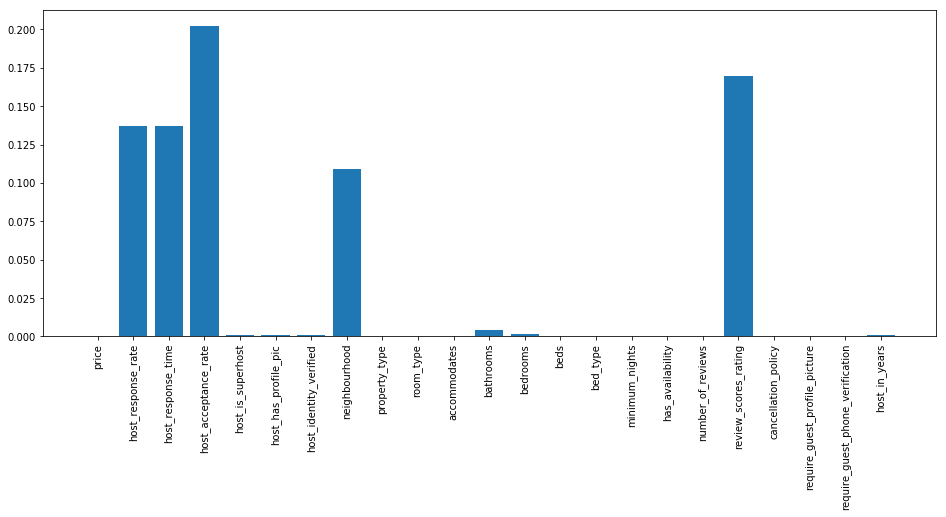

In [8]:
# Looking at the proportion of missing values per feature
d = pd.isnull(df).sum()
d = {'features' : d.index, 'missing_values': d, 'proportion_missing_values': (d/df.shape[0])}
d = pd.DataFrame(data=d).reset_index(drop=True)

# Figure representing the proportion of the missing values per feature
plt.figure(figsize=(16,6))
plt.xticks(rotation="vertical")
plt.bar(d.features, d.proportion_missing_values)

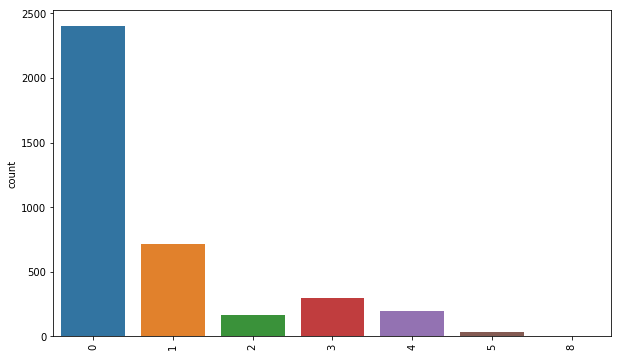

In [9]:
# Counting the number of rows with with X number of missing values
missing_rows = pd.isnull(df).sum(axis=1)
plt.figure(figsize=(10,6))
plt.xticks(rotation="vertical")
sns.countplot(missing_rows)

Index(['price', 'room_type', 'accommodates', 'bed_type', 'minimum_nights',
       'has_availability', 'number_of_reviews', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')


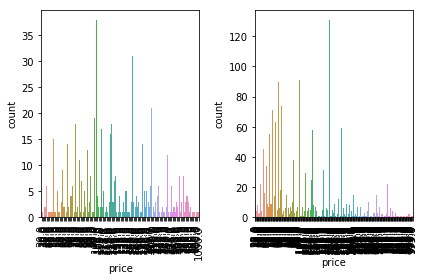

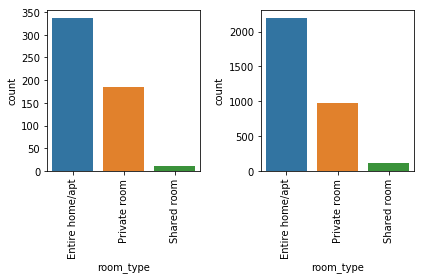

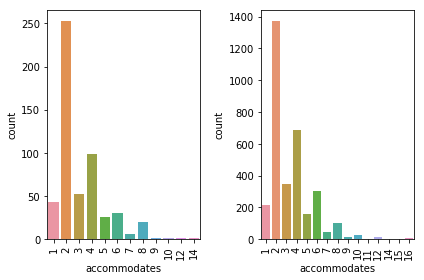

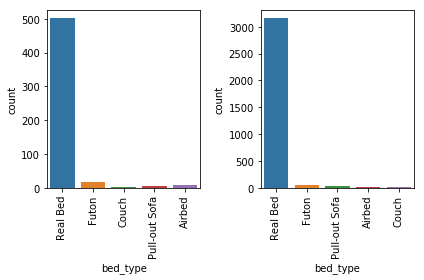

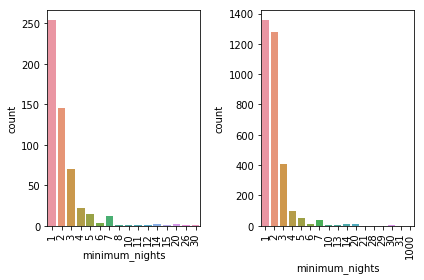

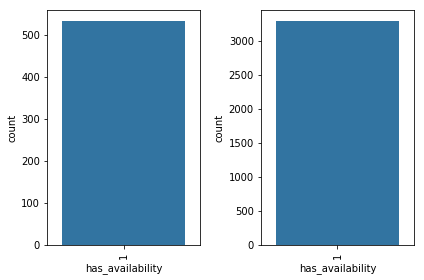

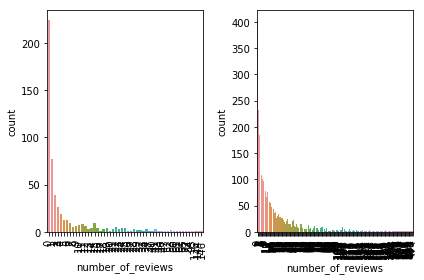

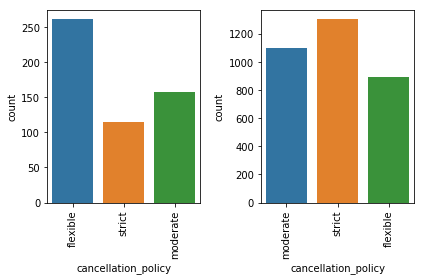

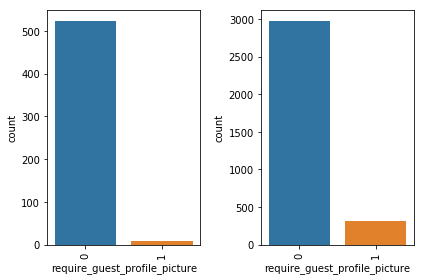

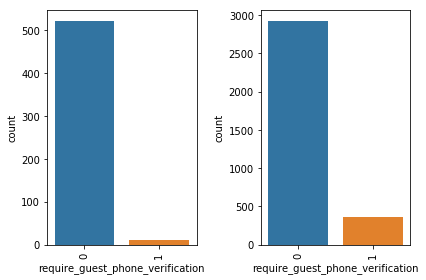

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
cutoff = 2
group_above_cutoff = df[pd.isnull(df).sum(axis=1) > cutoff]
group_below_cutoff = df[pd.isnull(df).sum(axis=1) <= cutoff]  

col_noNan = df.loc[:,pd.isnull(df).sum(axis=0) == 0].columns
print(col_noNan)

    
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for i in col_noNan:
    compare_plots(group_above_cutoff, group_below_cutoff, i)


#### 4.1.1-Conclusion regarding the distribution of the missing values

Unfortunately, if we were to remove the observations above a certain threshold of missing values, in our case setup at 2, the distribution for at least one feature would be affected (i.e., cancellation_policy). Consequently, I will not proceed to remove rows with missing values. I will proceed with imputation of the missing values.

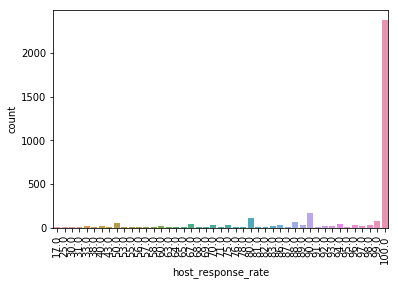

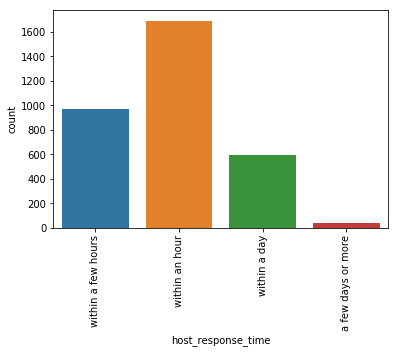

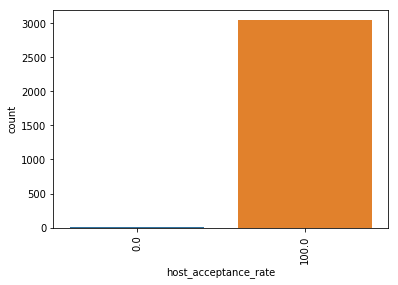

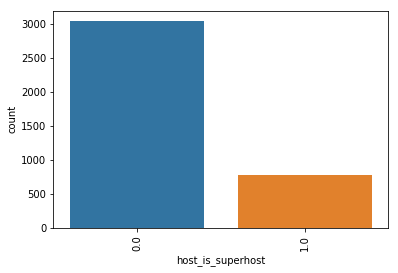

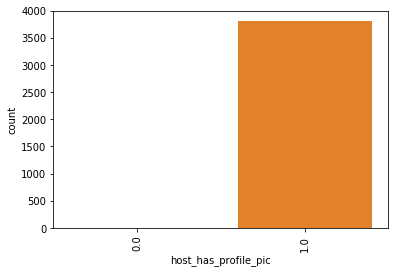

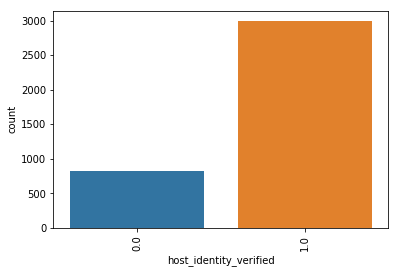

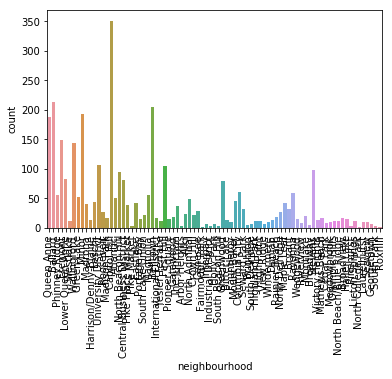

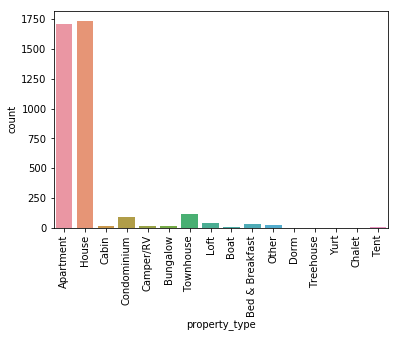

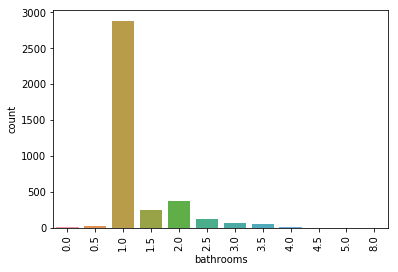

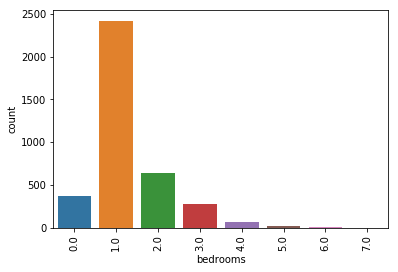

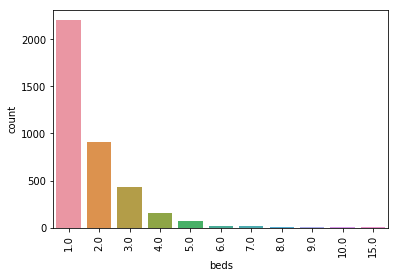

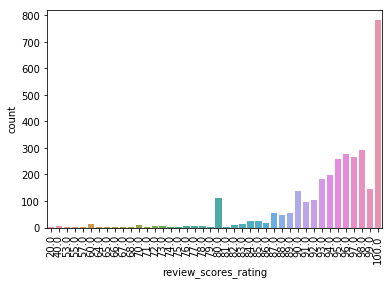

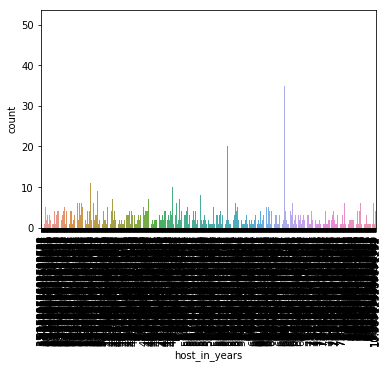

In [11]:
# Looking at the distribution of each feature with missing values in order to determine a potential imputation strategy
with_missing = df.columns[pd.isnull(df).sum() > 0]
for i in range(len(with_missing)):
    sns.countplot(df[with_missing[i]])
    plt.xticks(rotation="vertical")
    plt.show()

Looking at the distribution of each feature with missing values, we can determine which imputation strategy would be more adequate.
Consiedring the types of features and their respective distribution, using the "most_frequent" strategy seems like a good option.


### 4.2-Imputation of the missing values

In [12]:
# Preparing for imputation of missing values
feat2impute = ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 
                 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
                 'neighbourhood', 'property_type', 'bathrooms', 'bedrooms', 'beds']

# Imputing categorical features with the most frequent value observed
df = cat_imputer('most_frequent', df, feat2impute)

# Impute numerical features with median
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())
df['host_in_years'] = df['host_in_years'].fillna(df['host_in_years'].median())

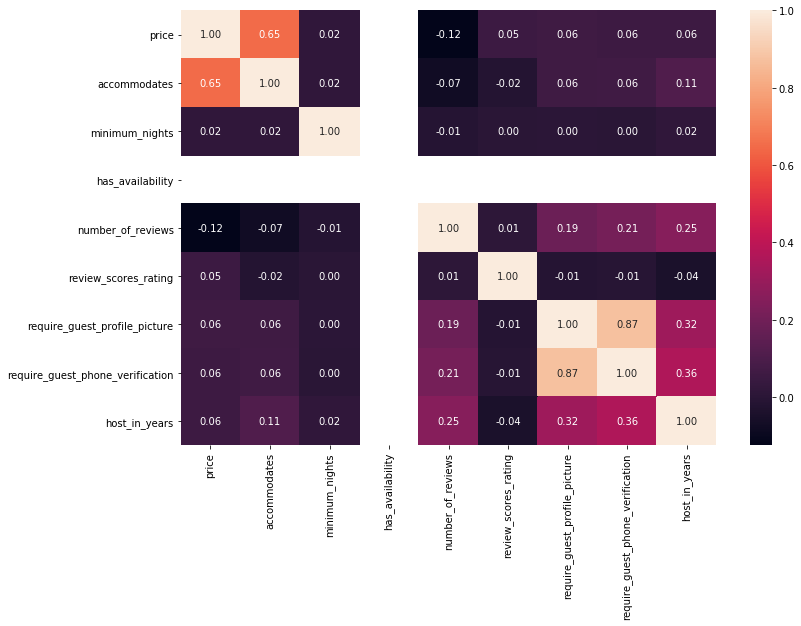

In [13]:
# Generate the cross-correlation between features
plt.figure(figsize=(12,8))
m = df.corr()
sns.heatmap(m, annot=True, fmt=".2f")


We can appreciate that the feature 'has_availability' has the same value for each data point. Therefore, it doesn't offer any variance, so we will remove it.

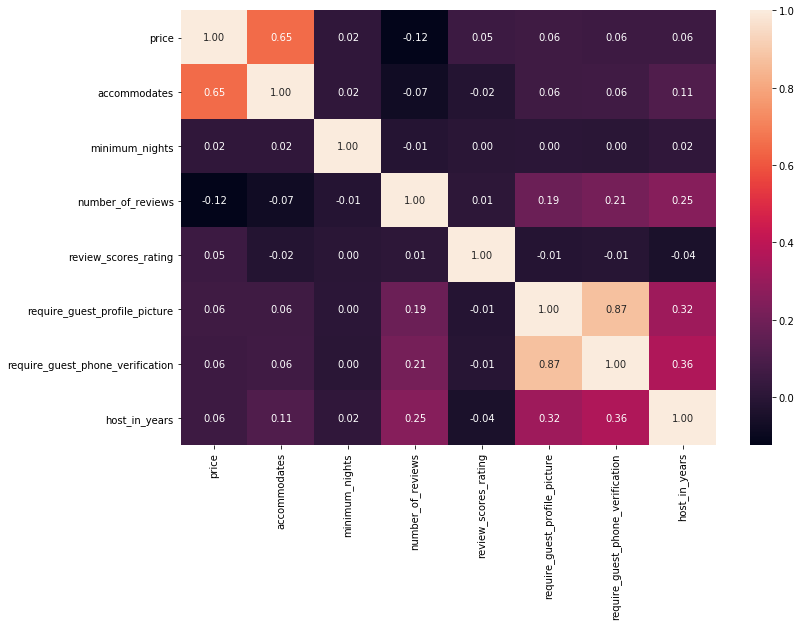

In [14]:
# Removing the 'has_availability feature
df = df.drop('has_availability', axis=1)
plt.figure(figsize=(12,8))
m = df.corr()
sns.heatmap(m, annot=True, fmt=".2f")


## 5-Data Analysis

In this section, we will perfomr the adequate calculations in order to answer our three questions of interest

### 5.1-Question 1:
### 5.1.1-Is there a correlation between the price for one night with the review_scores_rating for apartments?

In [15]:
# For simplicity, we will only consider 5 types of homes listed below.
housing = ['Apartment', 'House', 'Townhouse', 'Condominium', 'Loft'] 
sub_df = df[df['property_type'].apply(lambda x : x in housing)]

# Considering only housing with "Real Bed" and generating a new feature to help compare the listings: price_per_bed
sub_df = sub_df[sub_df['bed_type'] == 'Real Bed']
sub_df['price_per_bed'] = sub_df['price']/sub_df['beds']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

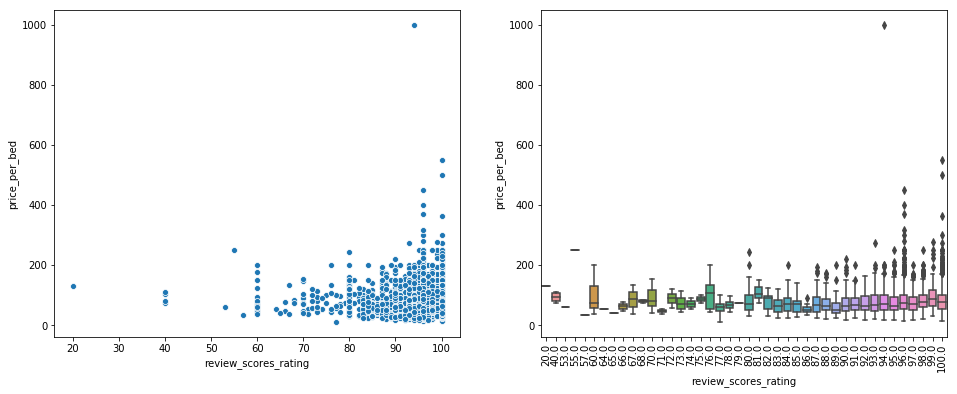

In [16]:
# Plotting the price_per_bed against the review_scores_rating
sub_df["price_per_bed"] = sub_df['price_per_bed'].astype(float)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.scatterplot(sub_df['review_scores_rating'], sub_df['price_per_bed'])
plt.subplot(1,2,2)
sns.boxplot(sub_df['review_scores_rating'], sub_df['price_per_bed'])
plt.xticks(rotation='vertical')

Even though there seems to be a positive relationship between the two features, the boxplot reveals otherwise. 

## 5.2-Question 2
### 5.2.1-Is there a difference in pricing between regular versus superhosts?

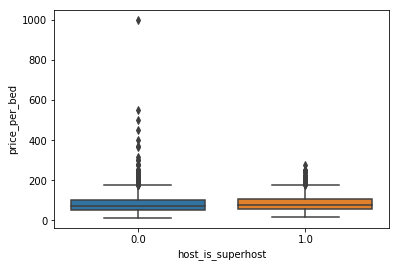

In [17]:
sns.boxplot(sub_df['host_is_superhost'], sub_df['price_per_bed'])

In [18]:
# T-test considering price per bed and whether a host is qualified as a superhost or not
print("Mean for price per bed for a regular host is {}:".format(round(sub_df[sub_df['host_is_superhost'] == 0]['price_per_bed'].mean(),2)))
print("Mean for price per bed for a super host  is {}:".format(round(sub_df[sub_df['host_is_superhost'] == 1]['price_per_bed'].mean(),2)))
stats.ttest_ind(sub_df[sub_df['host_is_superhost'] == 0]['price_per_bed'], 
                sub_df[sub_df['host_is_superhost'] == 1]['price_per_bed'])

Mean for price per bed for a regular host is 80.83:
Mean for price per bed for a super host  is 87.1:


Ttest_indResult(statistic=-3.3067243748550443, pvalue=0.0009533612487075971)

## 5.3-Question 3
### 5.3.1-Is there a difference in the years of experience between regular versus superhosts?

In [19]:
print('Average years of experience of regular hosts: {}'.format(round(sub_df[sub_df['host_is_superhost'] == 0]['host_in_years'].mean(),2))) 
print('Average years of experience of superhost hosts: {}'.format(round(sub_df[sub_df['host_is_superhost'] == 1]['host_in_years'].mean(),2))) 

stats.ttest_ind(sub_df[sub_df['host_is_superhost'] == 0]['host_in_years'], 
               sub_df[sub_df['host_is_superhost'] == 1]['host_in_years'])

Average years of experience of regular hosts: 5.47
Average years of experience of superhost hosts: 5.66


Ttest_indResult(statistic=-2.884879306656004, pvalue=0.003939309029125778)

## 5.4-Question 4 (Extra question not reported in the blog)
### 5.4.1-Is there a difference in the type of homes offered between regular versus superhosts?

             property_type  proportion  category
House                  370    0.511757         1
Apartment              309    0.427386         1
Townhouse               21    0.029046         1
Condominium             13    0.017981         1
Loft                    10    0.013831         1
Apartment             1312    0.465744         0
House                 1309    0.464679         0
Townhouse               92    0.032659         0
Condominium             76    0.026979         0
Loft                    28    0.009940         0


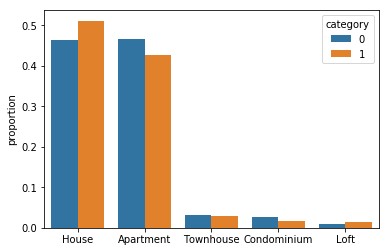

In [20]:
# Subsetting superhosts and generating the proportion of each type of homes
superhost = sub_df[sub_df['host_is_superhost'] == 1]
superhost = pd.DataFrame(data=superhost['property_type'].value_counts())
superhost['proportion'] = superhost['property_type']/superhost['property_type'].sum()
superhost['category'] = 1

# Subsetting regular hosts and generating the proportion of each type of homes
not_superhost = sub_df[sub_df['host_is_superhost'] == 0]
not_superhost = pd.DataFrame(data=not_superhost['property_type'].value_counts())
not_superhost['proportion'] = not_superhost['property_type']/(not_superhost['property_type'].sum())
not_superhost['category'] = 0

tmp = pd.concat([superhost, not_superhost], axis=0)
print(tmp)
sns.barplot(tmp.index, tmp['proportion'], hue=tmp['category'])


In [21]:
# Calculating a t-test assessing if a difference is observed between regular versus superhosts in terms
# of each housing type
type_home = ["House", "Apartment", "Townhouse", "Condominium", "Loft"]

for housing in type_home:
    count = ([not_superhost['property_type'][housing], superhost['property_type'][housing]])
    nobs = ([not_superhost['property_type'].sum(), superhost['property_type'].sum()])
    stat, pval = proportions_ztest(count, nobs)
    print('The T-stats: {}; the p-value: {} for {}'.format(round(stat,2), round(pval,3), housing))



The T-stats: -2.26; the p-value: 0.024 for House
The T-stats: 1.85; the p-value: 0.065 for Apartment
The T-stats: 0.49; the p-value: 0.622 for Townhouse
The T-stats: 1.38; the p-value: 0.168 for Condominium
The T-stats: -0.91; the p-value: 0.365 for Loft


## 6-Conclusion

In summary, we addressed three questions to understand how a successful listing is being recognized as a traveler. As stated earlier, we asked these three questions:

    - Is there a Price Difference in Terms of the Price Paid for a Bed Between a Regular Versus a Superhost?
    - Is There a Difference in the Years of Experience Between Regular versus a Superhost?
    - Is There a Difference in the Type of Housing Offered by Regular versus Superhosts?

Our analysis revealed that superhosts charged more for a bed, although they have longer experience in hosting and they offer a greater proportion of houses as opposed to any other types of accommodations.

We can conclude that you will have a better chance of having a great experience if you stay with a superhost. However, it would be wise to still consider regular hosts as most of them are trying to get their credentials up to become a superhost. In the end, becoming a superhost is a work in progress, and because of the way the platform works, hosts should try their best to offer the best experience in order to stay in business. Consequently, it is definitely plausible that you could have a wonderful experience, and for a few bucks cheaper. 